In [15]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="arc2face/config.json", local_dir="./models")
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="arc2face/diffusion_pytorch_model.safetensors", local_dir="./models")
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="encoder/config.json", local_dir="./models")
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="encoder/pytorch_model.bin", local_dir="./models")

'models/encoder/pytorch_model.bin'

In [11]:
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="arcface.onnx", local_dir="./models/antelopev2")


'models/antelopev2/arcface.onnx'

In [1]:
import sys
sys.path.append('./arc2face')

In [2]:
from huggingface_hub import hf_hub_download
from diffusers import (
    StableDiffusionPipeline,
    UNet2DConditionModel,
    DPMSolverMultistepScheduler,
)

from arc2face import CLIPTextModelWrapper, project_face_embs

import torch
from insightface.app import FaceAnalysis
from PIL import Image
import numpy as np

# Arc2Face is built upon SD1.5
# The repo below can be used instead of the now deprecated 'runwayml/stable-diffusion-v1-5'
base_model = 'stable-diffusion-v1-5/stable-diffusion-v1-5'

encoder = CLIPTextModelWrapper.from_pretrained(
    'models', subfolder="encoder", torch_dtype=torch.float16
)

unet = UNet2DConditionModel.from_pretrained(
    'models', subfolder="arc2face", torch_dtype=torch.float16
)

pipeline = StableDiffusionPipeline.from_pretrained(
        base_model,
        text_encoder=encoder,
        unet=unet,
        torch_dtype=torch.float16,
        safety_checker=None
    )

/home/admin/miniconda3/envs/arc2face/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/admin/miniconda3/envs/arc2face/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 29.68it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diff

In [3]:
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to('cuda')

In [4]:
app = FaceAnalysis(name='antelopev2', root='./', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

img = np.array(Image.open('assets/examples/joacquin.png'))[:,:,::-1]
faces = app.get(img)
faces = sorted(faces, key=lambda x:(x['bbox'][2]-x['bbox'][0])*(x['bbox'][3]-x['bbox'][1]))[-1]  # select largest face (if more than one detected)
id_emb = torch.tensor(faces['embedding'], dtype=torch.float16)[None].cuda()
id_emb = id_emb/torch.norm(id_emb, dim=1, keepdim=True)   # normalize embedding
id_emb = project_face_embs(pipeline, id_emb)    # pass through the encoder

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: ./models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'C

/home/admin/miniconda3/envs/arc2face/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [5]:
num_images = 1
images = pipeline(prompt_embeds=id_emb, num_inference_steps=25, guidance_scale=3.0, num_images_per_prompt=num_images).images


100%|██████████| 25/25 [02:23<00:00,  5.75s/it]


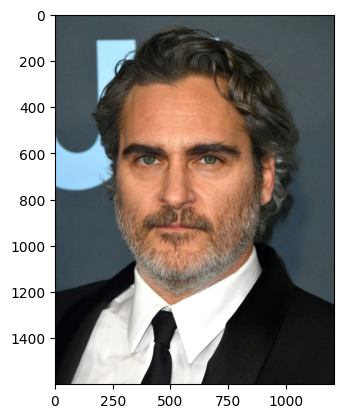

In [6]:
import matplotlib.pyplot as plt
img = np.array(Image.open('assets/examples/joacquin.png'))
plt.imshow(img)


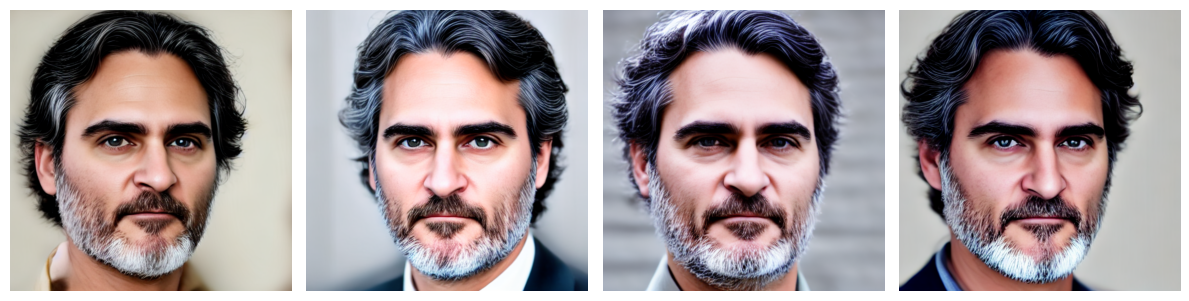

In [11]:

fig, axs = plt.subplots(1, num_images, figsize=(12, 6))

# Loop through the images and corresponding subplot axes
for i, imag in enumerate(images):
    axs[i].imshow(imag)
    axs[i].axis('off')  # Hide the axes for better display

# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
from diffusers import LCMScheduler

pipeline.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")
pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
images = pipeline(prompt_embeds=id_emb, num_inference_steps=2, guidance_scale=1.0, num_images_per_prompt=num_images).images


100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


In [1]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="controlnet/config.json", local_dir="./models")
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="controlnet/diffusion_pytorch_model.safetensors", local_dir="./models")


/home/admin/miniconda3/envs/arc2face/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'models/controlnet/diffusion_pytorch_model.safetensors'